# Testes atividade 18/06/2025

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

import LangGraphAgent
import GraphRAGAgent

agent1 = LangGraphAgent.compilar_agente()
agent2 = GraphRAGAgent.compilar_agente()

perguntas = (
    (
        "Quantas notas fiscais estão na base de dados?", 
        "Temos 100 notas fiscais na base de dados", 
        "MATCH (i:invoice) RETURN count(i) AS Total_de_Notas"
    ),
    (
        "Qual o valor total das notas emitidas entre os dias 10 de Janeiro de 2024 e 20 de Janeiro de 2024", 
        "Neste período, foram emitidas notas que somam o valor de R$ 1,340,519.56",
        "MATCH (p:party)<-[:ISSUED_BY]-(i:invoice) WHERE i.issueDateTime >= datetime('2024-01-20') AND i.issueDateTime <= datetime('2024-01-30') WITH p, sum(i.totalValue) AS Total_faturado RETURN p.name AS Empresa, Total_faturado ORDER BY Total_faturado DESC LIMIT 1"
    ),
    (
        "Qual a empresa que mais fez compras (recebeu notas) no estado do Paraná?",
        "A empresa, no estado do Paraná, que mais recebeu emissão de notas foi a UNIVERSIDADE FEDERAL DO PARANÀ",
        "MATCH (i:invoice)-[:ISSUED_TO]->(p:party)-[:LOCATED_IN]->(s:state) WHERE s.stateName = 'Paraná' WITH p, i RETURN p.name AS Empresa, sum(i.totalValue) AS Total_faturado ORDER BY Total_faturado DESC LIMIT 1"
    ),
    (
        "Alguma empresa comprou alimentos?",
        "Sim. Algumas empresas compraram produtos alimentícios, como pão francês, tomate salada, quiabo e batat doce",
        f"WITH genai.vector.encode('Alimentos', 'OpenAI', {{token:'{OPENAI_API_KEY}', model:'text-embedding-3-large'}}) AS query_vector CALL db.index.vector.queryNodes('productServiceDescriptions_vectIdx', 1000, query_vector) YIELD node, score WHERE score > 0.70 MATCH (node)<-[:REFERS_TO_PRODUCT]-(ii:invoiceItem)<-[:HAS_ITEM]-(i:invoice)-[:ISSUED_TO]->(p:party) RETURN p.name AS Nome_da_empresa, node.description AS Descrição, node.ncmshDescription AS DescriçãoNCMSH, score ORDER BY score DESC LIMIT 5"
    ),
    (
        "Qual o valor total das notas emitidas sobre materiais escolares?",
        "Parece que foram gastos cerca de R$ 294,673.35 com materiais escolares",
        f"WITH genai.vector.encode('materiais escolares', 'OpenAI', {{token:'{OPENAI_API_KEY}', model:'text-embedding-3-large'}}) AS query_vector CALL db.index.vector.queryNodes('productServiceDescriptions_vectIdx', 6000, query_vector) YIELD node, score WHERE score > 0.70 MATCH (node)<-[:REFERS_TO_PRODUCT]-(ii:invoiceItem) RETURN sum(ii.totalItemPrice) AS ValorTotal"
    )
)

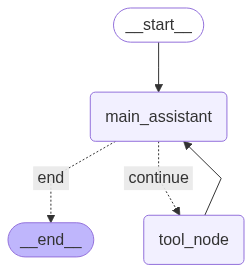

In [3]:
agent1.view()

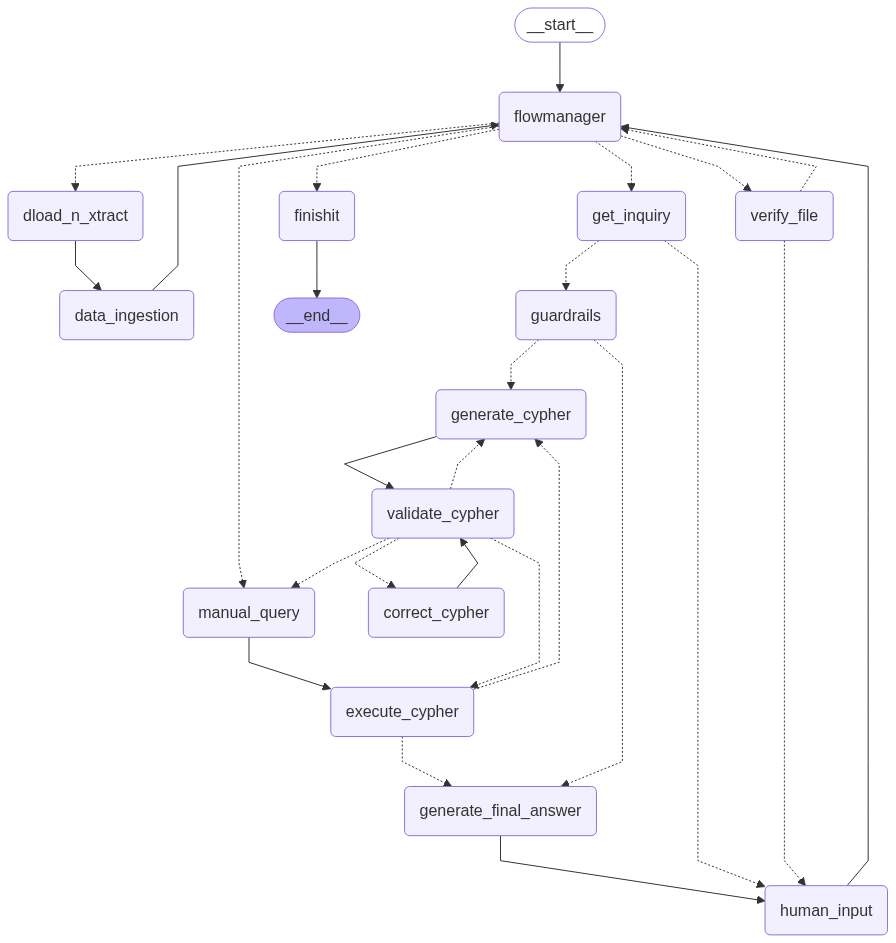

In [4]:
agent2.view()

In [9]:
ag1_answer = []
for question, answer, _ in perguntas:
    print("question:", question)
    print("ground truth:", answer)
    output = agent1.call(question)
    ag1_answer.append((question, output['final_answer']))
    print("agent answer:", output['final_answer'])
    print(20*"-")

question: Quantas notas fiscais estão na base de dados?
ground truth: Temos 100 notas fiscais na base de dados
agent answer: There are 200 unique invoices in the database.
--------------------
question: Qual o valor total das notas emitidas entre os dias 10 de Janeiro de 2024 e 20 de Janeiro de 2024
ground truth: Neste período, foram emitidas notas que somam o valor de R$ 1,340,519.56
agent answer: 1,340,519.56
--------------------
question: Qual a empresa que mais fez compras (recebeu notas) no estado do Paraná?
ground truth: A empresa, no estado do Paraná, que mais recebeu emissão de notas foi a UNIVERSIDADE FEDERAL DO PARANÀ
agent answer: According to the data provided, there are no recipients (companies) that received invoices in the state of Paraná.
--------------------
question: Alguma empresa comprou alimentos?
ground truth: Sim. Algumas empresas compraram produtos alimentícios, como pão francês, tomate salada, quiabo e batat doce
agent answer: Sim, algumas empresas compraram al

In [10]:
ag1_answer

[('Quantas notas fiscais estão na base de dados?',
  'There are 200 unique invoices in the database.'),
 ('Qual o valor total das notas emitidas entre os dias 10 de Janeiro de 2024 e 20 de Janeiro de 2024',
  '1,340,519.56'),
 ('Qual a empresa que mais fez compras (recebeu notas) no estado do Paraná?',
  'According to the data provided, there are no recipients (companies) that received invoices in the state of Paraná.'),
 ('Alguma empresa comprou alimentos?',
  'Sim, algumas empresas compraram alimentos. Identificamos a "FUNDACAO UNIVERSIDADE FEDERAL DE MS" e "SUPERINTENDENCIA REGIONAL SUDESTE I" comprando "AGUA MINERAL NATURAL".'),
 ('Qual o valor total das notas emitidas sobre materiais escolares?',
  'The total value of invoices emitted for school materials is 531.82.')]

In [6]:
ag2_answer = []
agent2.config = None
for question, answer, _ in perguntas:
    output = await agent2.call(question, jump_state=True )
    ag2_answer.append((question, "\n".join(output.values['messages'][-1].content.split("\n")[0:-1]),output.values['cypher_statement'] ))
    print("ground truth:", answer)
    print(20*"-")
    agent2.config = None

{'node': 'flow_manager', 'status': 'Thinking'}
{'node': 'get_inquiry', 'status': 'identifying question'}
{'node': 'guardrail', 'status': 'Testing guardrails'}
{'node': 'generate_cypher', 'status': 'generating cypher query'}
{'node': 'validate_cypher', 'status': 'checking for cypher statement errors'}
{'node': 'execute_cypher', 'status': 'Excetute query'}
{'node': 'generate_final_answer', 'status': 'Generating Final answer'}
================================ Human Message =================================

Quantas notas fiscais estão na base de dados?
================================ Human Message =================================

Na base de dados, há um total de 100 notas fiscais.

Você tem mais alguma pergunta, gostaria de trabalhar em um arquivo diferente ou deseja sair?
ground truth: Temos 100 notas fiscais na base de dados
--------------------
{'node': 'flow_manager', 'status': 'Thinking'}
{'node': 'get_inquiry', 'status': 'identifying question'}
{'node': 'guardrail', 'status': 'Te

In [11]:
# COmparação perguntas e respostas

for i in range(5):
    print(f"PERGUNTA 0{i+1}:", perguntas[i][0])
    print("AGENTE 1 -", ag1_answer[i][1])
    print("AGENTE 2 -", ag2_answer[i][1])
    print("RESPOSTA CORRETA:", perguntas[i][1])
    print(30*"-")

PERGUNTA 01: Quantas notas fiscais estão na base de dados?
AGENTE 1 - There are 200 unique invoices in the database.
AGENTE 2 - Na base de dados, há um total de 100 notas fiscais.

RESPOSTA CORRETA: Temos 100 notas fiscais na base de dados
------------------------------
PERGUNTA 02: Qual o valor total das notas emitidas entre os dias 10 de Janeiro de 2024 e 20 de Janeiro de 2024
AGENTE 1 - 1,340,519.56
AGENTE 2 - O valor total das notas emitidas entre os dias 10 de Janeiro de 2024 e 20 de Janeiro de 2024 é de R$ 1.340.519,56.

RESPOSTA CORRETA: Neste período, foram emitidas notas que somam o valor de R$ 1,340,519.56
------------------------------
PERGUNTA 03: Qual a empresa que mais fez compras (recebeu notas) no estado do Paraná?
AGENTE 1 - According to the data provided, there are no recipients (companies) that received invoices in the state of Paraná.
AGENTE 2 - A empresa que mais fez compras (recebeu notas) no estado do Paraná é a UNIVERSIDADE FEDERAL DO PARANÁ, com um total fatura